# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup posts on a variety of topics. You'll train classifiers to distinguish posts by topics inferred from the text. Whereas with digit classification, where each input is relatively dense (represented as a 28x28 matrix of pixels, many of which are non-zero), here each document is relatively sparse (represented as a bag-of-words). Only a few words of the total vocabulary are active in any given document. The assumption is that a label depends only on the count of words, not their order.

The `sklearn` documentation on feature extraction may be useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on Slack, but <b> please prepare your own write-up with your own code. </b>

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk

Load the data, stripping out metadata so that only textual features will be used, and restricting documents to 4 specific topics. By default, newsgroups data is split into training and test sets, but here the test set gets further split into development and test sets.  (If you remove the categories argument from the fetch function calls, you'd get documents from all 20 topics.)

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test  = fetch_20newsgroups(subset='test',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)

num_test = int(len(newsgroups_test.target) / 2)
test_data, test_labels   = newsgroups_test.data[num_test:], newsgroups_test.target[num_test:]
dev_data, dev_labels     = newsgroups_test.data[:num_test], newsgroups_test.target[:num_test]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('dev label shape:',      dev_labels.shape)
print('test label shape:',     test_labels.shape)
print('labels names:',         newsgroups_train.target_names)
print('labels names:',         newsgroups_test.target_names)
#print(test_labels,dev_labels,train_labels)

training label shape: (2034,)
dev label shape: (676,)
test label shape: (677,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


### Part 1:

For each of the first 5 training examples, print the text of the message along with the label.

In [3]:
def P1(num_examples=5):
    ### STUDENT START ###
    for i in range(num_examples):
        print("\n")
        print("#################################################")
        print("Message Example :",i+1)
        print("#################################################")
        ## The intresting observations is that while converting categories list into training and testing data, 
        ## it gets sorted and then labels are generated. Hence using target names of training data instead of 
        ## categories list
        print("\n", "Message Label : ", newsgroups_train.target_names[train_labels[i]], 
              "\n\n", "########## BEGIN MESSAGE TEXT FOR MESSAGE ", i+1,"##########\n\n", 
              train_data[i], "\n\n", "########## END MESSAGE TEXT FOR MESSAGE ", i+1,"##########")
    ### STUDENT END ###

P1(5)



#################################################
Message Example : 1
#################################################

 Message Label :  comp.graphics 

 ########## BEGIN MESSAGE TEXT FOR MESSAGE  1 ##########

 Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych 

 ########## END MESSAGE TEXT FOR MESSAGE  1 ##########


#################################################
Message Example : 2
##############################################

### Part 2:

Transform the training data into a matrix of **word** unigram feature vectors.  What is the size of the vocabulary? What is the average number of non-zero features per example?  What is the fraction of the non-zero entries in the matrix?  What are the 0th and last feature strings (in alphabetical order)?<br/>
_Use `CountVectorization` and its `.fit_transform` method.  Use `.nnz` and `.shape` attributes, and `.get_feature_names` method._

Now transform the training data into a matrix of **word** unigram feature vectors using your own vocabulary with these 4 words: ["atheism", "graphics", "space", "religion"].  Confirm the size of the vocabulary. What is the average number of non-zero features per example?<br/>
_Use `CountVectorization(vocabulary=...)` and its `.transform` method._

Now transform the training data into a matrix of **character** bigram and trigram feature vectors.  What is the size of the vocabulary?<br/>
_Use `CountVectorization(analyzer=..., ngram_range=...)` and its `.fit_transform` method._

Now transform the training data into a matrix of **word** unigram feature vectors and prune words that appear in fewer than 10 documents.  What is the size of the vocabulary?<br/>
_Use `CountVectorization(min_df=...)` and its `.fit_transform` method._

Now again transform the training data into a matrix of **word** unigram feature vectors. What is the fraction of words in the development vocabulary that is missing from the training vocabulary?<br/>
_Hint: Build vocabularies for both train and dev and look at the size of the difference._

Notes:
* `.fit_transform` makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").
* `.fit_transform` and `.transform` return sparse matrix objects.  See about them at http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html.  

In [4]:
def P2():
    ### STUDENT START ###

    #Transforming the training data into a matrix of word unigram feature vectors.
    vectorizer = CountVectorizer()
    X1 = vectorizer.fit_transform(train_data)

    print("The size of the vocabulary (unique words) : {}".format(X1.shape[1]))

    nonzero_count = 0
    for i in range(X1.shape[0]):        
        nonzero_count += X1[i].nnz
    avg_nnz = nonzero_count / X1.shape[0]

    print("The average number of non-zero features per example : {0:.2f}".format(avg_nnz))

    tot_pt_nnz = (X1.nnz/(X1.shape[0]*X1.shape[1]))*100
    
    print("The fraction of the non-zero entries in the matrix : {0:.2f}%".format(tot_pt_nnz))
    
    print("The alphabetically 0th word feature : \"{}\"".format(vectorizer.get_feature_names()[0]))
    
    print("The alphabetically last word feature : \"{}\""
          .format(vectorizer.get_feature_names()[len(vectorizer.get_feature_names())-1]))
    
    #Transforming the training data into a matrix of word unigram feature vectors using custom vocabulary
    customVocab = ["atheism", "graphics", "space", "religion"]
    
    vectorizer2 = CountVectorizer(min_df=1)
    Y = vectorizer2.fit(customVocab) 
    Y = Y.transform(train_data)

    nonzero_count = 0

    for i in range(Y.shape[0]):        
        nonzero_count += Y[i].nnz
    avg_nnz = nonzero_count = 0 / Y.shape[0]

    print("The average number of non-zero features per example using custom vocabulary : {0:.2f}".format(avg_nnz))
    
    #Transforming the training data into a matrix of character bigram and trigram feature vectors.
    bigram_vectorizer = CountVectorizer(analyzer = "char", ngram_range=(1,2))
    X2 = bigram_vectorizer.fit_transform(train_data)
    
    print("The size of the vocabulary (bigram corpus) : {}".format(X2.shape[1]))
    
    trigram_vectorizer = CountVectorizer(analyzer = "char", ngram_range=(1,3))
    X3 = trigram_vectorizer.fit_transform(train_data)
    
    print("The size of the vocabulary (trigram corpus) : {}".format(X3.shape[1]))
    
    #Transforming the training data into a matrix of word unigram feature vectors and prune words 
    #that appear in fewer than 10 documents
    vectorizer3 = CountVectorizer(min_df=10)
    X4 = vectorizer3.fit_transform(train_data)
    
    print("With a 10 word minimum occurrance cut off, the size of the vocabulary (unique words) : {} "
          .format(X4.shape[1]))
    print("The size of the vocabulary with prune words that appear in fewer than 10 documents : {}"
          .format(X1.shape[1] - X4.shape[1]))
    
    #Finding the fraction of words in the development vocabulary that is missing from the training vocabulary
    vectorizer4 = CountVectorizer()
    X5 = vectorizer4.fit_transform(dev_data)
    
    missing_words = list(set(vectorizer4.get_feature_names()) - set(vectorizer.get_feature_names()))
    
    print("The words in the development vocabulary that is missing from the training vocabulary : {} "
          .format(len(missing_words)))
    ### STUDENT END ###

P2()

The size of the vocabulary (unique words) : 26879
The average number of non-zero features per example : 96.71
The fraction of the non-zero entries in the matrix : 0.36%
The alphabetically 0th word feature : "00"
The alphabetically last word feature : "zyxel"
The average number of non-zero features per example using custom vocabulary : 0.00
The size of the vocabulary (bigram corpus) : 3370
The size of the vocabulary (trigram corpus) : 35557
With a 10 word minimum occurrance cut off, the size of the vocabulary (unique words) : 3064 
The size of the vocabulary with prune words that appear in fewer than 10 documents : 23815
The words in the development vocabulary that is missing from the training vocabulary : 4027 


### Part 3:

Transform the training and development data to matrices of word unigram feature vectors.

1. Produce several k-Nearest Neigbors models by varying k, including one with k set to optimize f1 score.  For each model, show the k value and f1 score.
1. Produce several Naive Bayes models by varying smoothing (alpha), including one with alpha set approximately to optimize f1 score.  For each model, show the alpha value and f1 score.
1. Produce several Logistic Regression models by varying L2 regularization strength (C), including one with C set approximately to optimize f1 score.  For each model, show the C value, f1 score, and sum of squared weights for each topic.

* Why doesn't k-Nearest Neighbors work well for this problem?
* Why doesn't Logistic Regression work as well as Naive Bayes does?
* What is the relationship between logistic regression's sum of squared weights vs. C value?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer` and its `.fit_transform` and `.transform` methods to transform data.
* You can use `KNeighborsClassifier(...)` to produce a k-Nearest Neighbors model.
* You can use `MultinomialNB(...)` to produce a Naive Bayes model.
* You can use `LogisticRegression(C=..., solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.

In [9]:
from sklearn.model_selection import GridSearchCV
#import warnings
#warnings.warn(CV_WARNING, FutureWarning)


def P3():
    ### STUDENT START ###
    #Transforming the training and development data to matrices of word unigram feature vectors
    vectorizer1 = CountVectorizer()
    X1 = vectorizer1.fit_transform(train_data)  
        
    vectorizer2 = CountVectorizer()
    X2 = vectorizer2.fit(train_data)
    X2 = X2.transform(dev_data)
    #X2 = vectorizer1.fit_transform(dev_data)
    #print(X2)
    
    #Producing several k-Nearest Neigbors models by varying k
    print("########## Analysis with k-Nearest Neigbors models ##########")
    for k in range(10):
        kNN_model = KNeighborsClassifier(n_neighbors=k+1)
        kNN_model.fit(X1,train_labels)
        dev_predicted_labels = kNN_model.predict(X2)
        f1score = metrics.f1_score(dev_labels, dev_predicted_labels, average='weighted')
        print("F1 score with k = {} is : {}".format(k+1,f1score))
        
        
    k_values = {"n_neighbors":list(range(1,10))} # for GridSearchCV to find best k value   
    model1 = KNeighborsClassifier()
    kneighbor_model = GridSearchCV(model1, k_values, scoring="f1_weighted")
    kneighbor_model.fit(X1, train_labels)
    f1score = kneighbor_model.score(X2, dev_labels) 
    print("Optimized F1 score is for model with k = {} and it is = {}"
          .format(kneighbor_model.best_params_["n_neighbors"],f1score))
    
    
    #Analysis with several Naive Bayes models by varying smoothing (alpha)
    print("\n\n########## Analysis with Naive Bayes models ##########")
    alpha_values = [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]
    for alpha_val in alpha_values:
        NB_model = MultinomialNB(alpha=alpha_val)
        NB_model.fit(X1,train_labels)
        dev_predicted_labels = NB_model.predict(X2)
        f1score = metrics.f1_score(dev_labels, dev_predicted_labels, average='weighted')
        print("F1 score with alpha = {} is : {}".format(alpha_val,f1score))
    
    alphas = {'alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
    model2 = MultinomialNB()
    multinomial_model = GridSearchCV(model2, alphas, scoring="f1_weighted")
    multinomial_model.fit(X1, train_labels)
    f1score = multinomial_model.score(X2, dev_labels) 
    multinomial_model.best_params_["alpha"]
    print("Optimized F1 score for a Multinomial Naive Bayes Model (with an alpha of {}) = {}"
              .format(multinomial_model.best_params_["alpha"],f1score))
    
    #Analysis with several Logistic Regression models by varying L2 regularization strength (C)
    print("\n\n########## Analysis with Logistic Regression models ##########")
    C_values = [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]
    for C_val in C_values:
        LR_model = LogisticRegression(C=C_val,solver="liblinear", multi_class="auto")
        LR_model.fit(X1,train_labels)
        dev_predicted_labels = LR_model.predict(X2)
        f1score = metrics.f1_score(dev_labels, dev_predicted_labels, average='weighted')
        print("F1 score with C = {} is : {}".format(C_val,f1score))
        for j in range(len(categories)):
            print("Sum of squared weights for label = {} and C = {} is {:.2f}"
                  .format(newsgroups_test.target_names[j], C_val, np.sum(np.square(LR_model.coef_[j]))))
        
    C_vals = {'C': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
    model3 = LogisticRegression(solver="liblinear", multi_class="auto")
    regression_model = GridSearchCV(model3, C_vals, scoring="f1_weighted")
    regression_model.fit(X1, train_labels)
    regression_model.best_params_
    f1score = regression_model.score(X2, dev_labels)
    regression_model.get_params 
    print("Optimized F1 score for a Logistic Regression Model (with a regression strength C of {}) = {}"
          .format(regression_model.best_params_["C"],f1score))
    ### STUDENT END ###
    


P3()

########## Analysis with k-Nearest Neigbors models ##########
F1 score with k = 1 is : 0.3805030018531525
F1 score with k = 2 is : 0.38054212404441684
F1 score with k = 3 is : 0.4084150225437623
F1 score with k = 4 is : 0.4031227993847515
F1 score with k = 5 is : 0.4287607236218357
F1 score with k = 6 is : 0.4466650540867595
F1 score with k = 7 is : 0.45047910006117586
F1 score with k = 8 is : 0.44698358117081094
F1 score with k = 9 is : 0.4365666176198027
F1 score with k = 10 is : 0.4278502905941064
Optimized F1 score is for model with k = 7 and it is = 0.45047910006117586


########## Analysis with Naive Bayes models ##########
F1 score with alpha = 0.0001 is : 0.7628348704826354
F1 score with alpha = 0.001 is : 0.7702518836155706
F1 score with alpha = 0.01 is : 0.7751663218544357
F1 score with alpha = 0.1 is : 0.7903052385098862
F1 score with alpha = 0.5 is : 0.7862862961995258
F1 score with alpha = 1.0 is : 0.7777320236017224
F1 score with alpha = 2.0 is : 0.7689966472342658
F1 sco

ANSWER:

1) K-nearest neighbors does not work well for this problem because it has very high dimensionality. In other words, there are many features and they may not be very close together.

2) For the idea of Naive Bayes v/s Logistic Regression, the independence assumption of Naive Bayes may be giving an advantage to generality of model at this data size. Logistic Regression may work well with significanly high number of documents.

3) As the strength of the regularization term decreases (i.e. as value of C increases), the sum of squared weights for each label increases. 

### Part 4:

Transform the data to a matrix of word **bigram** feature vectors.  Produce a Logistic Regression model.  For each topic, find the 5 features with the largest weights (that's 20 features in total).  Show a 20 row (features) x 4 column (topics) table of the weights.

Do you see any surprising features in this table?

Notes:
* Train on the transformed training data.
* You can use `CountVectorizer` and its `.fit_transform` method to transform data.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `np.argsort` to get indices sorted by element value. 

/Users/prasadvalavade/anaconda3/lib/python3.7/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


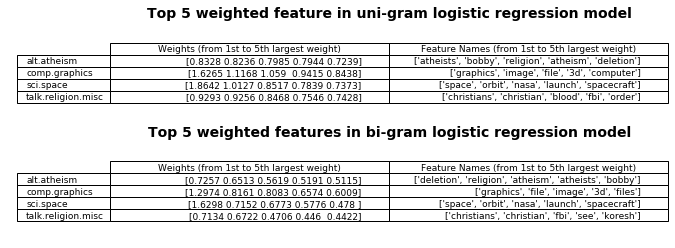

In [10]:
def P4():
    ### STUDENT START ###
    # First vectorize our train_data and dev_data 
    vectorizer1 = CountVectorizer()
    X1 = vectorizer1.fit_transform(train_data)  
    
    # Next a vectorizer for bigrams
    vectorizer2 = CountVectorizer(ngram_range=(1,2))
    X2 = vectorizer2.fit_transform(train_data) 
    
    # Use most optimized C reg. term
    C_val = 0.5

    # Simple logistic regression model
    regression_model1 = LogisticRegression(C=C_val,solver="liblinear", multi_class="auto")
    regression_model1.fit(X1, train_labels)
    
    # Bigram logistic regression model
    regression_model2 = LogisticRegression(C=C_val,solver="liblinear", multi_class="auto")
    regression_model2.fit(X2, train_labels)
  
    # Used for getting lists of 5 largest weight features for unigram and bigram models
    large_weights_uni = [] 
    large_weights_bi = [] 
    large_name_uni = []
    large_name_bi = []
    tmp1 = []
    tmp2 = []
    
    # The weights
    for i in range(4):
        weights_uni = np.sort(regression_model1.coef_[i])[::-1]
        weights_bi = np.sort(regression_model2.coef_[i])[::-1]
        large_weights_uni.append(weights_uni[:5])
        large_weights_bi.append(weights_bi[:5])
        
    # The feature name (word)   
    for i in range (4):
        for j in range(5):
            key = int(np.where(regression_model1.coef_ == large_weights_uni[i][j])[1])
            tmp1.append(vectorizer1.get_feature_names()[key])
            key = int(np.where(regression_model2.coef_ == large_weights_bi[i][j])[1])
            tmp2.append(vectorizer2.get_feature_names()[key])            
        large_name_uni.append(tmp1)
        large_name_bi.append(tmp2)
        tmp1 = []
        tmp2 = []
    
    # Clean decimal place for plotting
    large_weights_uni = np.round(large_weights_uni, decimals=4)
    large_weights_bi = np.round(large_weights_bi, decimals=4)
    
    #print(large_weights_uni)
    #print(large_name_uni)
    
    # Draw tables for the data
    colnames = ["Weights (from 1st to 5th largest weight)", 
    "Feature Names (from 1st to 5th largest weight)"]
    
    fig, axs =plt.subplots(2,1, figsize=(10,4))
    
    axs[0].axis('tight')
    axs[0].axis('off')
    axs[0].set_title("Top 5 weighted feature in uni-gram logistic regression model",
                       fontsize=14, fontweight="bold")
    axs[1].axis('tight')
    axs[1].axis('off')
    axs[1].set_title("Top 5 weighted features in bi-gram logistic regression model",
                       fontsize=14, fontweight="bold")
    
    the_table1 = axs[0].table(cellText=list(zip(large_weights_uni,large_name_uni)),
                          rowLabels=newsgroups_test.target_names,
                          colLabels=colnames,
                          loc="center")
    
    the_table1 = axs[1].table(cellText=list(zip(large_weights_bi,large_name_bi)),
                          rowLabels=newsgroups_test.target_names,
                          colLabels=colnames,
                          loc="center")   
    
    plt.show()
    ### STUDENT END ###

P4()

ANSWER:

1) The label "alt.atheism" strangely has the word "bobby" weighted very heavily on both the uni-gram and bi-gram logestic regressions. 

2) The label "talk.religion.misc" has the word fbi weighted heavily in both regression models. This word does not seem to be related to this topic

3) The label "comp.graphics" has 2 words file and files which are same/similar. 

4) It will be interesting to find out what is relevance of word "deletion" for the label "alt.atheism"

### Part 5:

To improve generalization, it is common to try preprocessing text in various ways before splitting into words. For example, you could try transforming strings to lower case, replacing sequences of numbers with single tokens, removing various non-letter characters, and shortening long words.

Produce a Logistic Regression model (with no preprocessing of text).  Evaluate and show its f1 score and size of the dictionary.

Produce an improved Logistic Regression model by preprocessing the text.  Evaluate and show its f1 score and size of the vocabulary.  Try for an improvement in f1 score of at least 0.02.

How much did the improved model reduce the vocabulary size?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer(preprocessor=...)` to preprocess strings with your own custom-defined function.
* `CountVectorizer` default is to preprocess strings to lower case.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.
* If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular.

In [11]:
def better_preprocessor(s):
    ### STUDENT START ###
    porter_stemmer=nltk.stem.PorterStemmer()
    text=s.lower() 
    text=re.sub("\\W"," ",text) # remove special chars
    text = re.sub(" \d+"," ", text) # remove numbers
    text=re.sub("\\s+(in|the|all|for|and|on)\\s+"," _connector_ ",text) # normalize certain words
    # stem words
    words=re.split("\\s+",text)
    stemmed_words=[porter_stemmer.stem(word=word) for word in words]
    return ' '.join(stemmed_words)
    ### STUDENT END ###

def P5():
    ### STUDENT START ###
    #processed_data = [better_preprocessor(s) for s in train_data]
    
    # With no pre-processing
    vectorizer1 = CountVectorizer()
    X1 = vectorizer1.fit_transform(train_data)
    
    # With pre-processing
    vectorizer2 = CountVectorizer(preprocessor=better_preprocessor)
    X2 = vectorizer2.fit_transform(train_data)
    
    # Vectorize the dev data for scoring our logistic regression models (without pre processing)
    vectorizer3 = CountVectorizer()
    Y1 = vectorizer3.fit(train_data)
    Y1 = Y1.transform(dev_data)
    
    # Vectorize the dev data for scoring our logistic regression models (with pre processing)
    #print(dev_data)
    vectorizer4 = CountVectorizer(preprocessor=better_preprocessor)
    Y2 = vectorizer4.fit(train_data)
    Y2 = Y2.transform(dev_data)
    
    
        
    # Use most optimized C reg. term
    C_val = 0.5
    
    # Logistic regression without pre-processing
    regression_model1 = LogisticRegression(C=C_val,solver="liblinear", multi_class="auto")
    regression_model1.fit(X1, train_labels)
    preds1 = regression_model1.predict(Y1)
    score1 = metrics.f1_score(dev_labels, preds1, average="weighted")
    print("F1 score for log. regression without pre-processing = {:.4f}".format(score1))
    
    # Logistic regression with pre-processing
    regression_model2 = LogisticRegression(C=C_val,solver="liblinear", multi_class="auto")
    regression_model2.fit(X2, train_labels)    
    preds2 = regression_model2.predict(Y2)    
    score2 = metrics.f1_score(dev_labels, preds2, average="weighted")    
    print("F1 score for log. regression with pre-processing = {:.4f}".format(score2)) 
    ### STUDENT END ###

P5()

F1 score for log. regression without pre-processing = 0.7085
F1 score for log. regression with pre-processing = 0.7127


Answer: From above score it is obsserved that there is imporvement in f1 score by 0.042

### Part 6:

The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. Logistic regression seeks the set of weights that minimizes errors in the training data AND has a small total size. The default L2 regularization computes this size as the sum of the squared weights (as in Part 3 above). L1 regularization computes this size as the sum of the absolute values of the weights. Whereas L2 regularization makes all the weights relatively small, L1 regularization drives many of the weights to 0, effectively removing unimportant features.

For several L1 regularization strengths ...<br/>
* Produce a Logistic Regression model using the **L1** regularization strength.  Reduce the vocabulary to only those features that have at least one non-zero weight among the four categories.  Produce a new Logistic Regression model using the reduced vocabulary and **L2** regularization strength of 0.5.  Evaluate and show the L1 regularization strength, vocabulary size, and f1 score associated with the new model.

Show a plot of f1 score vs. log vocabulary size.  Each point corresponds to a specific L1 regularization strength used to reduce the vocabulary.

How does performance of the models based on reduced vocabularies compare to that of a model based on the full vocabulary?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `LogisticRegression(..., penalty="l1")` to produce a logistic regression model using L1 regularization.
* You can use `LogisticRegression(..., penalty="l2")` to produce a logistic regression model using L2 regularization.
* You can use `LogisticRegression(..., tol=0.015)` to produce a logistic regression model using relaxed gradient descent convergence criteria.  The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.015 (the default is .0001).

############ L2 Regularization Analysis ############ 
F1 score for logistic regression with C=0.5 and L2 regularization = 0.7085
L2 regularization gives 0 weights that are equal to 0

############ L1 Regularization Analysis ############ 
F1 score for logistic regression with C=0.5 and L1 regularization = 0.6921
L1 regularization gives 106271 weights that are equal to 0.


/Users/prasadvalavade/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/prasadvalavade/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

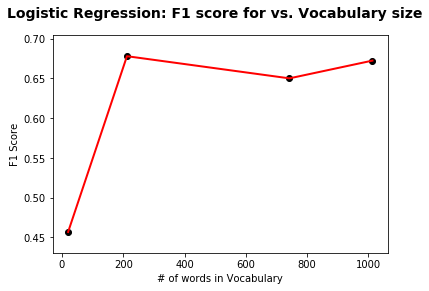

In [18]:
def P6():

    # Keep this random seed here to make comparison easier.
    np.random.seed(0)
    
    ### STUDENT START ###
    # Regularization strength term for upcoming log. reg. models
    c_vals = [0.01, 0.1, 0.5, 0.9]
    
    # First vectorize the train data
    vectorizer1 = CountVectorizer()
    X1 = vectorizer1.fit_transform(train_data)
    
    # Next vectorize the dev data for prediction
    vectorizer2 = CountVectorizer()
    Y1 = vectorizer2.fit(train_data)
    Y1 = vectorizer2.transform(dev_data)
    
    # L2 regularization
    regression_model1 = LogisticRegression(penalty="l2",C=c_vals[2],solver="liblinear", multi_class="auto",max_iter=10000)
    regression_model1.fit(X1, train_labels)
    preds1 = regression_model1.predict(Y1)
    score1 = metrics.f1_score(dev_labels, preds1, average="weighted")
    print("############ L2 Regularization Analysis ############ ")
    print("F1 score for logistic regression with C=0.5 and L2 regularization = {:.4f}".format(score1))
    
    # Look at num of zero valued weights
    L2_zeros = np.sum(regression_model1.coef_ == 0.)
    print("L2 regularization gives {} weights that are equal to 0".format(L2_zeros)) 
    
    #L1 regularization
    regression_model2 = LogisticRegression(penalty="l1", C=0.5,solver="liblinear", multi_class="auto",tol=.015,max_iter=10000)
    regression_model2.fit(X1, train_labels)
    preds2 = regression_model2.predict(Y1)
    score2 = metrics.f1_score(dev_labels, preds2, average="weighted")
    print("\n############ L1 Regularization Analysis ############ ")
    print("F1 score for logistic regression with C=0.5 and L1 regularization = {:.4f}".format(score2))
    
    # Look at num of zero valued weights   
    L1_zeros = np.sum(regression_model2.coef_ == 0.)
    
    
    print("L1 regularization gives {} weights that are equal to 0.".format(L1_zeros))
    
    # Some models to get a smaller vocabulary with non-zero features for a few L1 reg. values 
    regression_model3 = LogisticRegression(penalty="l1", C=c_vals[0],solver="liblinear", multi_class="auto",tol=.015,max_iter=10000)
    regression_model3.fit(X1, train_labels)
    
    regression_model4 = LogisticRegression(penalty="l1", C=c_vals[1],solver="liblinear", multi_class="auto",tol=.015,max_iter=10000)
    regression_model4.fit(X1, train_labels)
    
    regression_model5 = LogisticRegression(penalty="l1", C=c_vals[3],solver="liblinear", multi_class="auto",tol=.015,max_iter=10000)
    regression_model5.fit(X1, train_labels)
    
    # for extracting vocab at each C value
    all_models = [regression_model3.coef_, regression_model4.coef_, regression_model2.coef_, regression_model5.coef_]
    cut_down_vocab_part = []
    cut_down_vocab_comp = []
    temp = []
    
    for curr_model in all_models:
        for j in range(4):
            for k in range(26879):
                if (curr_model[j,k] != 0):
                    temp += [k]
            cut_down_vocab_part += list(set(temp) - set(cut_down_vocab_part))
            temp = []
        cut_down_vocab_comp.append(cut_down_vocab_part)
        cut_down_vocab_part = []

        
    # Get all the original vocab words 
    small_vocab = []
    small_vocab_comp = []
    X2 = vectorizer2.fit(train_data)    
    total_vocab = list(X2.get_feature_names())
    for i in range(4):
        for j in cut_down_vocab_comp[i]:
            small_vocab.append(total_vocab[j])
        small_vocab_comp.append(small_vocab)
        small_vocab = []

    # Get all f-scores
    f1_scores = []
    for i in range(4):
        # Vectorize the new small vocab list
        vectorizer3 = CountVectorizer()
        X2_small = vectorizer3.fit(small_vocab_comp[i])
        X2_small = vectorizer3.transform(train_data)
        
        # Vectorize the dev data on new vocab
        vectorizer4 = CountVectorizer()
        Y2_small = vectorizer3.fit(small_vocab_comp[i])
        Y2_small = vectorizer3.transform(dev_data)
        
        # New log. model with small vocab
        regression_model3 = LogisticRegression(C=c_vals[i])
        regression_model3.fit(X2_small, train_labels)
        preds3 = regression_model3.predict(Y2_small)
        
        f1_scores.append(metrics.f1_score(dev_labels, preds3, average="weighted"))
    
    # Make list of vocab sizes to plot in next step
    vocab_size = []
    for i in range(4):
        vocab_size.append(len(small_vocab_comp[i]))
    
    # Plot F1 score vs. Vocab Size for Logistic Regression
    fig = plt.figure()
    fig.suptitle("Logistic Regression: F1 score for vs. Vocabulary size", fontsize=14, fontweight="bold")
    plt.ylabel("F1 Score")
    plt.xlabel("# of words in Vocabulary")
    plt.scatter(vocab_size, f1_scores, color="black") 
    plt.plot(vocab_size, f1_scores, color="red", linewidth=2)
    plt.show()

    ### STUDENT END ###


P6()

ANSWER: F1 Score sgnificantly increases as number od words in vocabulary increases and remains more or less stable after a particular point (In this case when number of words are just more than 200)

### Part 7:

How is `TfidfVectorizer` different than `CountVectorizer`?

Produce a Logistic Regression model based on data represented in tf-idf form, with L2 regularization strength of 100.  Evaluate and show the f1 score.  How is `TfidfVectorizer` different than `CountVectorizer`?

Show the 3 documents with highest R ratio, where ...<br/>
$R\,ratio = maximum\,predicted\,probability \div predicted\,probability\,of\,correct\,label$

Explain what the R ratio describes.  What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

Note:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `TfidfVectorizer` and its `.fit_transform` method to transform data to tf-idf form.
* You can use `LogisticRegression(C=100, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `LogisticRegression`'s `.predict_proba` method to access predicted probabilities.

In [23]:
def P7():
    ### STUDENT START ###
    vectorizer1 = TfidfVectorizer()
    X1 = vectorizer1.fit_transform(train_data)
    
    vectorizer2 = TfidfVectorizer()
    Y1 = vectorizer2.fit(train_data)
    Y1 = Y1.transform(dev_data)

    regression_model1 = LogisticRegression(C=100,solver="liblinear", multi_class="auto")
    regression_model1.fit(X1, train_labels)
   
    # Calculate R-ratio for dev data
    prob = regression_model1.predict_proba(Y1)
    preds = regression_model1.predict(Y1)
    R_vals = []

    for i in range(prob.shape[0]):
        R_vals.append(max(prob[i])/prob[i][dev_labels[i]])
    R_vals_highest = (np.sort(R_vals)[::-1])[:3]

    
    # Put the Highest R_val Messages in an array
    hard_messages = []
    hard_messages_indices = []
    for i in range(len(R_vals_highest)):
        key = int(np.where(R_vals == R_vals_highest[i])[0])
        hard_messages.append(dev_data[key])
        hard_messages_indices.append(key)



    hard_messages_pred_label = preds[hard_messages_indices]
    hard_messages_true_label = dev_labels[hard_messages_indices]
    



    for i in range(len(hard_messages)):
        print("\n")
        print("***************************")
        print("#{} Most Mis-Matched Message".format(i+1))
        print("***************************")
        print("\n")
        print("R score : {}".format(R_vals_highest[i]))
        print("The label as per Logistic Regression : \"{}\" ".format(categories[hard_messages_pred_label[i]]))
        print("The actual label : \"{}\"".format(categories[hard_messages_true_label[i]]))
        print("\n\n", "----BEGIN MESSAGE TEXT---- ", "\n\n", 
              hard_messages[i], "\n\n", "----END MESSAGE TEXT----")
    ### STUDENT END ###

P7()



***************************
#1 Most Mis-Matched Message
***************************


R score : 929.3559098496164
The label as per Logistic Regression : "talk.religion.misc" 
The actual label : "sci.space"


 ----BEGIN MESSAGE TEXT----  

 I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, but people are welcome
to make *verbatim* copies for personal use. People can recuperate the
actual cos

ANSWER:

#### Difference between `TfidfVectorizer` and `CountVectorizer`:

`CountVectorizer` simply counts number of words while `TfidfVectorizer` gives weights to every word based on their occurences across documents. To explain further, `TfidfVectorizer` reduces weights of those words which are occuring across documents. 

#### Analysis for Model error:

The correct label for the first message is "sci.space" but it has been labelled as "talk.religion.misc". The wrong classification can be attributed model's confusion betweeno same/similar words like "not-for-profit" available in both categories. The similar pattern can be observed in rest of the messages displayed.

Now this analysis can be connected to the mechanism of assigning weights by `TfidfVectorizer`. While it reduces weights of those words which are occuring across documents, it does not reduce weights for those words which are common to only few documents. This creates confusion for the model between labels for corresponding documents and ends up giving wrong prediction.



### Part 8 EXTRA CREDIT:

Produce a Logistic Regression model to implement your suggestion from Part 7.